In [2]:
###THIS METRIC GETS THE TOXIC MESSAGE COUNT PER USER IN A REPO###
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
###USER PICKS REPO TO MEASURE THIS METRIC###
repoName = input("input repo name:")

input repo name: Loris


In [ ]:
###GET TABLE OF ALL MESSAGES IN THIS REPO AND THEIR SENTIMENT SCORE###
repolist = pd.DataFrame()

repo_query = salc.sql.text(f"""
            SELECT
                repo.repo_id,
                repo.repo_name,
                date_trunc( 'month', message.msg_timestamp ) AS message_month,
                message.cntrb_id, 
                AVG (message_analysis.sentiment_score) AS average_sentiment
            FROM
                repo, message_analysis, message, issue_message_ref, issues 
                where message_analysis.msg_id = message.msg_id 
                and 
                issue_message_ref.issue_id = issues.issue_id  
                AND
                issue_message_ref.msg_id = message.msg_id 
                AND
                issues.repo_id = repo.repo_id 
                AND
                repo.repo_name = '""" + repoName + """'
            GROUP BY
                repo.repo_id,
                repo.repo_name,
                message.msg_timestamp, 
                message.cntrb_id 
            ORDER BY
                average_sentiment DESC,
                repo_id,
                message_month DESC;
    """)

repolist = pd.read_sql(repo_query, con=engine)

display(repolist)

repolist.dtypes

In [4]:
####THIS GETS A LIST OF ALL THE CONTRIBUTERS IN THE REPO###
repolist2 = pd.DataFrame()

repo_query2 = salc.sql.text(f"""
            SELECT 
                repo.repo_id,
                repo.repo_name,
                message.cntrb_id
            FROM
                repo, message_analysis, message, issue_message_ref, issues 
                where message_analysis.msg_id = message.msg_id 
                AND
                issue_message_ref.issue_id = issues.issue_id  
                AND
                issue_message_ref.msg_id = message.msg_id 
                AND
                issues.repo_id = repo.repo_id 
                AND
                repo.repo_name = '""" + repoName + """'
            GROUP BY
                repo.repo_id,
                repo.repo_name, 
                message.cntrb_id 
            ORDER BY
                repo_id
    """)

repolist2 = pd.read_sql(repo_query2, con=engine)

display(repolist2)

repolist.dtypes

,repo_id,repo_name,cntrb_id
0,26188,Loris,277109
1,26188,Loris,277456
2,26188,Loris,277532
3,26188,Loris,281788
4,26188,Loris,281876
...,...,...,...
117,26188,Loris,394582
118,26188,Loris,396107
119,26188,Loris,396858
120,26188,Loris,397003


repo_id                       int64
repo_name                    object
message_month        datetime64[ns]
cntrb_id                      int64
average_sentiment           float64
dtype: object

In [5]:
###THIS GIVES THE AVERAGE SENTIMENT OF ALL MESSAGES, THE TOTAL TOXIC MESSAGE COUNT, AND THE TOTAL MESSAGE COUNT###
#This isn't needed for this metric, but will be used in other metrics#
overall_score = sum(repolist.average_sentiment)/len(repolist.average_sentiment)
print(overall_score)

summ = 0
for i  in repolist.average_sentiment:
    if i < 0:
        summ = summ + 1
print(summ)
print(len(repolist))

0.06536233905501294
921
16137


In [6]:
###THIS TALLIES UP THE TOXIC MESSAGES FOR EACH USER###
ID_array = np.zeros(len(repolist2.cntrb_id))
Toxic_Count_Array = np.zeros(len(repolist2.cntrb_id))
contribIDs = []
messageCount = []
totalMessages = []
countBundle = []
totalMessageCount = 0
for i in range(30):
    toxicCount = 0
    for j in range(len(repolist.cntrb_id)):
        if repolist.cntrb_id[j] == repolist2.cntrb_id[i]:
            totalMessageCount += 1
            if repolist.average_sentiment[j] < 0:
                toxicCount = toxicCount + 1
    Toxic_Count_Array[i] = toxicCount
    contribIDs.append(str(repolist2.cntrb_id[i]))
    messageCount.append(toxicCount)
    print('ID:', repolist2.cntrb_id[i], 'toxic message count:', toxicCount)
    totalMessages.append(totalMessageCount)
    countBundle.append([toxicCount, totalMessageCount])
# print(contribIDs)
# print(messageCount)

ID: 277109 toxic message count: 0
ID: 277456 toxic message count: 0
ID: 277532 toxic message count: 0
ID: 281788 toxic message count: 3
ID: 281876 toxic message count: 1
ID: 297198 toxic message count: 13
ID: 297199 toxic message count: 1
ID: 297202 toxic message count: 18
ID: 297203 toxic message count: 13
ID: 297204 toxic message count: 3
ID: 297205 toxic message count: 2
ID: 297206 toxic message count: 27
ID: 297208 toxic message count: 2
ID: 297210 toxic message count: 1
ID: 297211 toxic message count: 1
ID: 297212 toxic message count: 5
ID: 297213 toxic message count: 12
ID: 297216 toxic message count: 9
ID: 297218 toxic message count: 10
ID: 297219 toxic message count: 54
ID: 297220 toxic message count: 56
ID: 297221 toxic message count: 0
ID: 297227 toxic message count: 0
ID: 297229 toxic message count: 2
ID: 297232 toxic message count: 13
ID: 297247 toxic message count: 0
ID: 297264 toxic message count: 0
ID: 297355 toxic message count: 14
ID: 297360 toxic message count: 177
ID

In [1]:
# sz = 5
# plt.scatter(repolist2.cntrb_id, Toxic_Count_Arra/y, sz)
print(type(contribIDs[0]))
print(messageCount)
# plt.bar(contribIDs, messageCount)
plt.figure(figsize=(30, 10))
chart = plt.bar(contribIDs, messageCount, 1)
plt.xticks(fontsize=18, rotate=80)
for i in plt.bar_label(chart):
    i.set_fontsize(20)
plt.axhline(y=75,linewidth=1, color='k', label='mean')


NameError: name 'contribIDs' is not defined

['277109', '277456', '277532', '281788', '281876', '297198', '297199', '297202', '297203', '297204', '297205', '297206', '297208', '297210', '297211', '297212', '297213', '297216', '297218', '297219', '297220', '297221', '297227', '297229', '297232', '297247', '297264', '297355', '297360', '297367']
[[0, 1], [0, 503], [0, 505], [3, 550], [1, 553], [13, 712], [1, 802], [18, 1350], [13, 1509], [3, 1591], [2, 1641], [27, 2141], [2, 2174], [1, 2227], [1, 2259], [5, 2377], [12, 2500], [9, 2772], [10, 2869], [54, 4602], [56, 5265], [0, 5275], [0, 5277], [2, 5362], [13, 5963], [0, 5967], [0, 5974], [14, 6181], [177, 8567], [0, 8586]]


(0.0, 100.0)

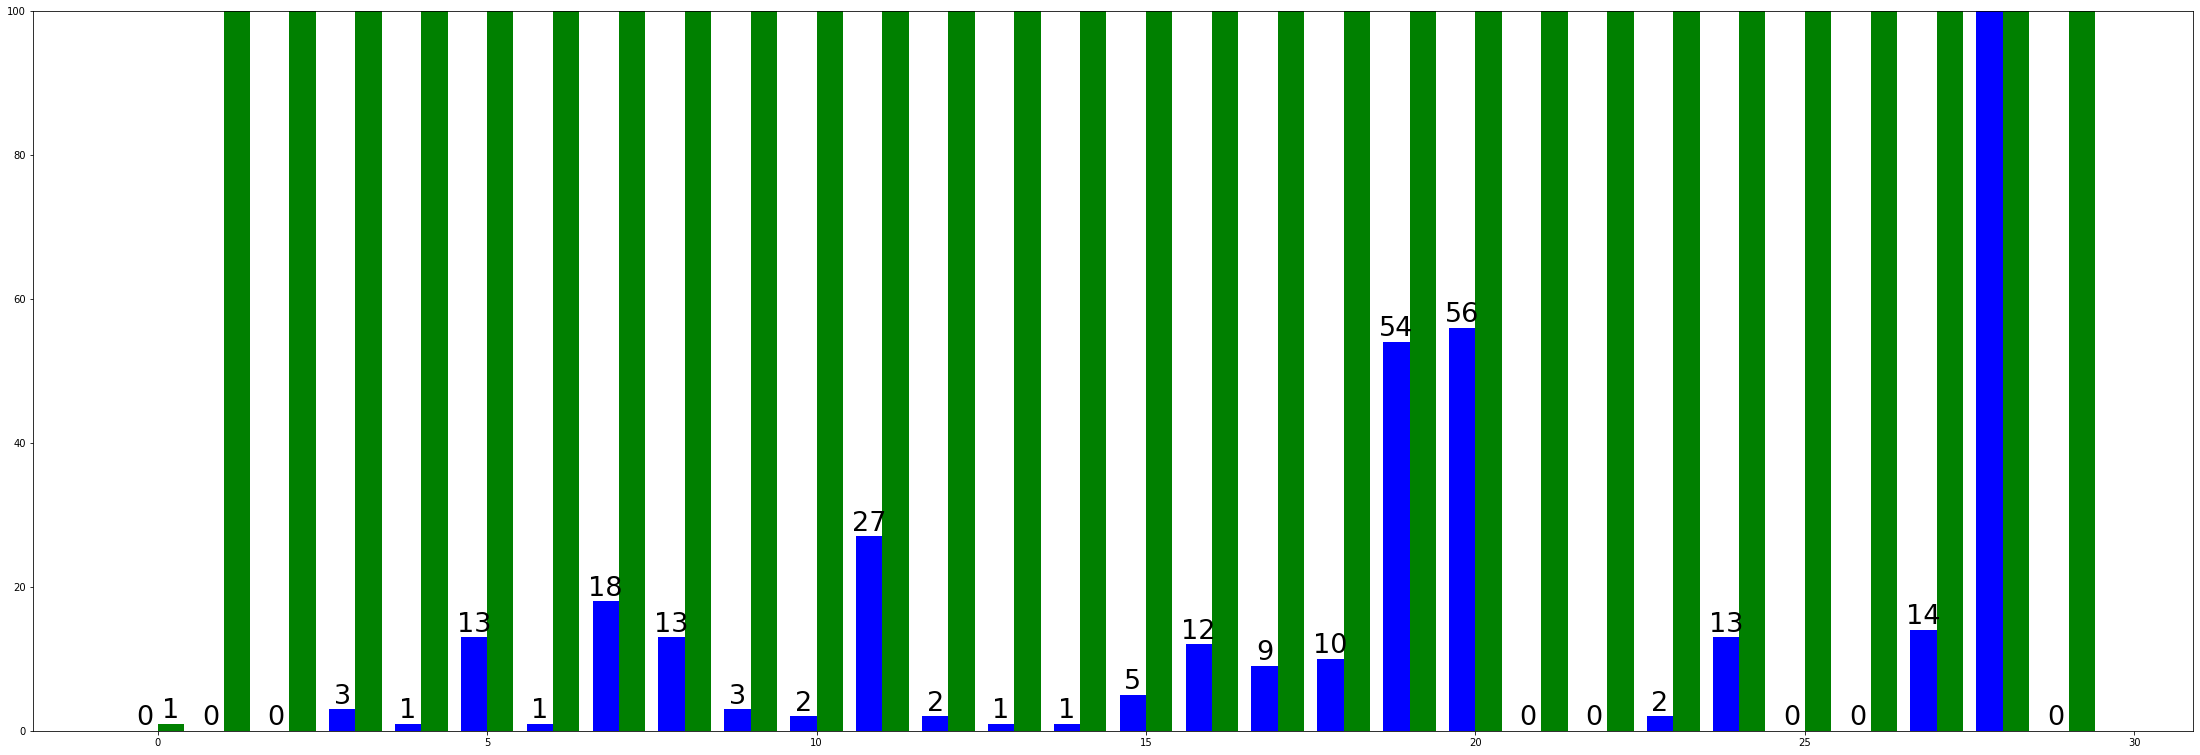

In [22]:
print(contribIDs)
print(countBundle)
X = np.arange(len(contribIDs))

fig = plt.figure(figsize=(30, 10))
ax = fig.add_axes([0,0,1,1])
bars1 = ax.bar(X - 0.2, messageCount, color = 'b', width = 0.4)
bars2 = ax.bar(X + 0.2, totalMessages, color = 'g', width = 0.4)
for i in plt.bar_label(bars1):
    i.set_fontsize(27)
for i in plt.bar_label(bars2):
    i.set_fontsize(27)
plt.ylim([0, 100])


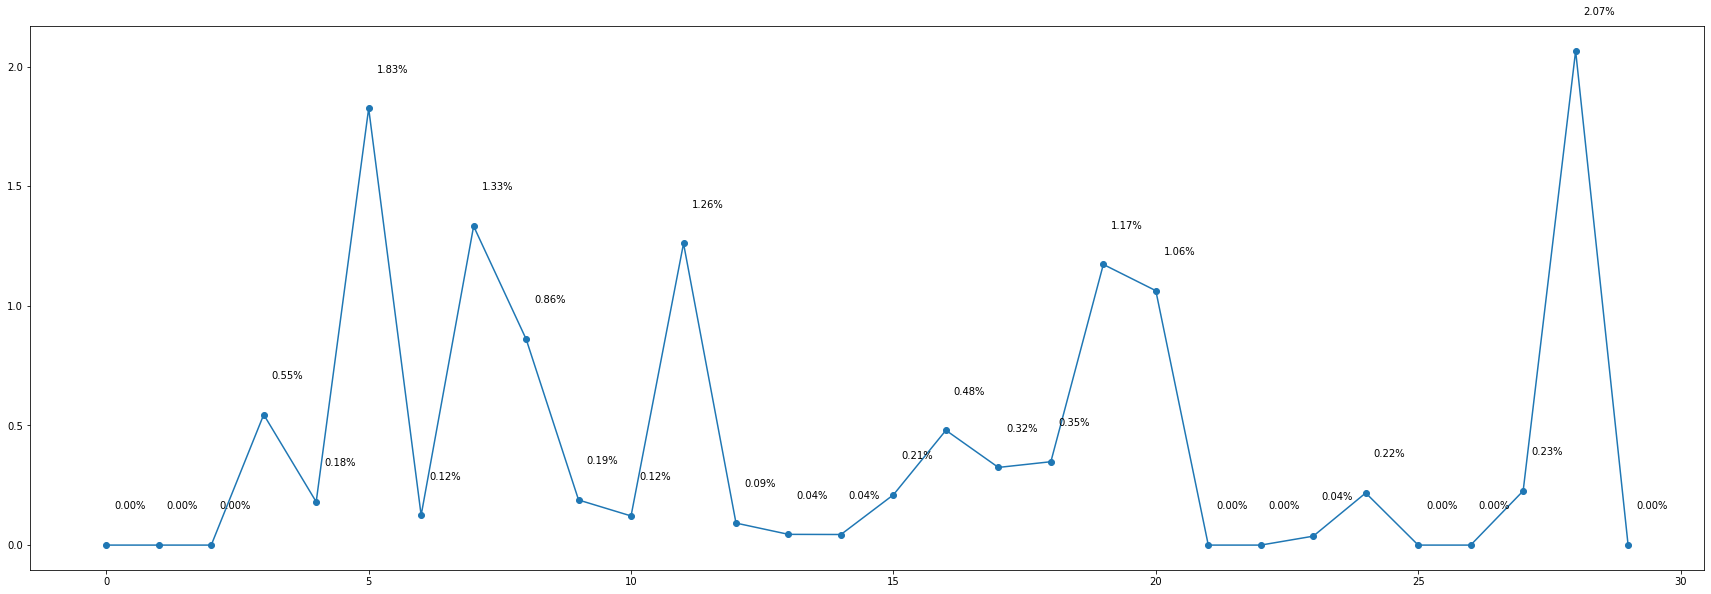

In [44]:
contribNum = []
for i in range(len(contribIDs)):
    contribNum.append(i)

x = contribNum
messagePercent = []
for i in range(len(contribIDs)):
    messagePercent.append(messageCount[i]/totalMessages[i] * 100)
y = messagePercent
fig = plt.figure(figsize=(30, 10))
graph = plt.scatter(x, y)
plt.plot(x,y)
for i in range(len(y)):
    plt.text(x[i] + .15, y[i] + .15, "{percent:.2f}%".format(percent= y[i]))
plt.show()